### Установка chromedriver

1. Скачать и установить google chrome браузер
2. Посмотреть версию браузера (настройки с троеточием справа -> Help -> About Google Chrome)
3. Скачать и установить google-chrome-driver версии, соответствующей версии браузера https://chromedriver.chromium.org/
4. Распаковать архив и положить в <путь к проекту>/bin/chromedriver
на виндоуз переименовать чтобы не было .exe в расширении, либо в переменной ниже поменять путь к драйверу

In [9]:
pip install -q selenium 

Note: you may need to restart the kernel to use updated packages.


### Конфиги

In [10]:
GAME_URL = "chrome://dino/"
CHROMEDRIVER_PATH = "./bin/chromedriver"

In [11]:
from enum import Enum
class Action(Enum):
    DO_NOTHING = 0
    JUMP = 1
    # TODO: Add action DUSK
    #DUSK = 2 

### Среда

In [12]:
import time
import os
import typing

import cv2

from PIL import ImageGrab

import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

In [21]:
# ОБЯЗАТЕЛЬНО TODO: Подобрать рамку под себя
# Создать environment (см. код ниже)
# Начать игру
# Подобрать различные варианты через ImageGrab.grab(bbox=(0, 210, 550, 350))

In [29]:
SCREEN_BBOX = (0, 200, 650, 400)
SCREEN_BBOX = (100, 150, 350, 450)
#SCREEN_BBOX = (90, 300, 400, 345)

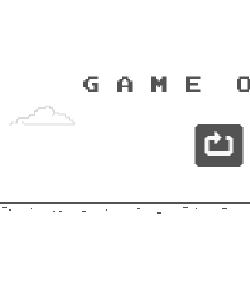

In [30]:
# Запускать для подбора бокса ПОСЛЕ создания энвайронмента ниже
ImageGrab.grab(bbox=SCREEN_BBOX)

In [35]:
class Environment:
    def __init__(
        self, 
        chrome_driver_path: str, 
        game_url: str, 
        speed: typing.Optional[int] = None,
        acceleration: typing.Optional[float] = None,
    ) -> None:
        self.driver = webdriver.Chrome(executable_path=chrome_driver_path)
        # Обязательно TODO: убедиться что эти параметры годятся 
        self.driver.set_window_position(x=-20, y=-20)
        self.driver.set_window_size(550, 450)
        try:
            self.driver.get('chrome://dino')
        except Exception:
            pass   # ignore
        
        if speed:
            self.driver.execute_script(f"Runner.instance_.setSpeed({speed})")
        
        if acceleration:
            self.driver.execute_script(f"Runner.config.ACCELERATION={acceleration}")

    def start_game(self):
        self.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.SPACE)
        time.sleep(2)
        
    def close_game(self):
        self.driver.close()
            
    def perform_action(self, action: Action) -> (typing.Optional[np.ndarray], float):
        state = self.get_screen()
        if action == Action.DO_NOTHING:
            pass
        elif action == Action.JUMP:
            # TODO: Принять решение не нужна ли тут какая-то пауза убедиться что прыжок закончили
            self.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.SPACE)
            time.sleep(0.5)
        elif action == Action.DUSK:
            # TODO: (ТОЛЬКО ЕСЛИ ДОБАВИЛИ СООТВЕТСТВУЮШИЙ ЭКШН В АГЕНТА) 
            # Если был выбран нырок, то возможно стоит подольше его подержать, а не просто один раз кликнуть
            self.driver.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARRAYS_DOWN)
        else:
            raise Exception(f"Unsupported action {action}")
        
        if self.has_crashed():
            return None, 0
        else:
            # TODO: Попробовать разные варианты вычисления награды. Может штрафовать за лишние прыжки, например
            reward = self.get_score() ** 1.6
        return state, reward
            
    def has_crashed(self) -> bool:
        return self.driver.execute_script("return Runner.instance_.crashed")
    
    def restart(self) -> None:
        self.driver.execute_script("Runner.instance_.restart()")

    def get_screen(self) -> np.ndarray:
        screen = ImageGrab.grab(bbox=SCREEN_BBOX)
        screen = np.array(screen)
        return self.preprocess_screen(screen)
        
    def preprocess_screen(self, screen: np.ndarray) -> np.ndarray:
        # TODO: Добавить больше препроцессинга. Возможные идеи:
        #    Убрать облака?
        #    Убрать линию "дороги"?
        #    Обрезать изображение?
        #    Сделать черно-белым?
        #    Поменять размер?
        #    Сделать динозавра прямоугольником? :) 
        #    Меньше будущей информации?
        #    Ваши идеи
        return cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
        
    def get_score(self) -> int:
        score_array = self.driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array)
        return int(score)


In [36]:
# TODO: Подобрать какая скорость больше подойдет
# TODO: Принять решение будете ли использовать ускорение или лучше задать его в ноль (тогда не будет птичек еще)

environment = Environment(CHROMEDRIVER_PATH, GAME_URL)

<ipython-input-35-14ff86949804>:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome(executable_path=chrome_driver_path)


In [37]:
environment.start_game()

In [38]:
environment.perform_action(Action.JUMP)

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 101.96145121984944)

In [39]:
environment.perform_action(Action.DO_NOTHING)

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 111.17464760577515)

### DQN

In [13]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DQN(nn.Module):
    def __init__(self, screen_width, screen_height, action_count):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        #conv1_out_width = self.conv2d_size_out(screen_width)
        #conv1_out_height = self.conv2d_size_out(screen_height)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)


        
        #self.flatten = nn.Flatten()
        #self.head = nn.Linear(conv1_out_width * conv1_out_height * 16, action_count)
        
        def conv2d_size_out(size, kernel_size=5, stride=2) -> int:
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(screen_width)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(screen_height)))
        
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, action_count)
        
    def forward(self, x):
        # TODO: Добавить различные сверточные слои / функции активации / и т.д.
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return self.head(x.view(x.size(0), -1))
    

In [14]:
screen_height = SCREEN_BBOX[3] - SCREEN_BBOX[1]
screen_width = SCREEN_BBOX[2] - SCREEN_BBOX[0]

screen_height, screen_width

(45, 310)

In [15]:
policy_net = DQN(screen_height, screen_width, len(Action)).to(device)

In [16]:
state = torch.from_numpy(environment.get_screen()).float()
batch_state = state.unsqueeze(0).unsqueeze(0)

batch_state.shape

torch.Size([1, 1, 45, 310])

In [17]:
policy_net(batch_state)

tensor([[0.0701, 0.3497]], grad_fn=<AddmmBackward>)

### Агент

In [18]:
import random 
import collections as col

Transition = col.namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = col.deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class Agent:
    
    # TODO: ВАЖНО: Подобрать параметры ниже    

    EXPLORATION_STEPS_COUNT = 40   # Количество шагов, когда совершаем ТОЛЬКО exploration 
    EPS_INITIAL = 0.9   # Начальное значение EPS, после которого начинаем подключать exploitation
    EPS_FINAL = 0.05   # Минимальное значение EPS, до которого дойдем
    EPS_DECAY_DELTA = 0.05   # Величина, на которую будем уменьшать EPS
    EPS_DECAY_STEPS_COUNT = 15  # Через сколько шагов будем снижать EPS
    
    
    
    def __init__(self) -> None:
        self.eps = 1    # По началу только exploration
        self.made_steps_count = 0
        self.n_actions = len(Action)
        self.policy_net = DQN(screen_height, screen_width, self.n_actions).to(device)
        self.optimizer = torch.optim.RMSprop(policy_net.parameters())
        self.memory = ReplayMemory(10000)
    
    def select_action(self, state: np.ndarray) -> Action:
        self.made_steps_count += 1
        
        # Пока еще только exploration
        if self.made_steps_count < self.EXPLORATION_STEPS_COUNT:
            self.eps = 1
        # Начинаем подключать exploitation
        elif self.made_steps_count == self.EXPLORATION_STEPS_COUNT:
            self.eps = self.EPS_INITIAL
        # Каждые EPS_DECAY_STEPS_COUNT шагов на константу уменьшаем eps если он получится не меньше чем EPS_FINAL
        elif self.made_steps_count % self.EPS_DECAY_STEPS_COUNT == 0 \
                and self.eps - self.EPS_DECAY_DELTA >= self.EPS_FINAL:
            self.eps -= self.EPS_DECAY_DELTA                        
        
        exploit_prob = random.random()
        if exploit_prob > self.eps:
            with torch.no_grad():
                # Сеть ожидает что у нас обязательно будет размерность для батча. Создаем фиктивную размерность 
                # Также создаем фиктивную размерность для числа каналов
                state_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
                batch_action_rewards = policy_net(state_batch)
                batch_argmax_actions = batch_action_rewards.max(1).indices
                # Взяли нулевой элемент, т.к. у нас батч всего из одного элемента
                action_ind = batch_argmax_actions.tolist()[0]
        else:
            action_ind = random.randrange(self.n_actions)        
        return Action(action_ind)    
    
    def update_reward(self, state: np.ndarray, action: Action, next_state: np.ndarray, reward: int) -> None:
        state_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
        next_state_batch = torch.from_numpy(next_state).float().unsqueeze(0).unsqueeze(0)
        # Индексы действий что мы проделали. Используется чтобы достать текушие оценки Q для проделанных действий
        action_batch = torch.from_numpy(np.array([action.value])).unsqueeze(0)
        #reward_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)

        # Получаем текущее "жадное" действие для уравнения Беллмана
        with torch.no_grad():
            next_state_values = policy_net(next_state_batch).max(1)[0]
            expected_state_action_values = (next_state_values * 0.99) + reward

        # Получаем текущее значение Q для проделанного действия    
        state_action_values = policy_net(state_batch).gather(1, action_batch.type(torch.int64))

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()    

In [19]:
agent = Agent()

### Цикл обучения

In [20]:
# TODO: число эпизодов подобрать
episodes_count = 200


for episode_num in range(episodes_count):
    print(f"Running episode {episode_num}")
    environment.restart()
    environment.start_game()
    
    while not environment.has_crashed():
        state = environment.get_screen()
        if not environment.has_crashed(): 
            action = agent.select_action(state)
            next_state, reward = environment.perform_action(action)
            # Не сломались пока выполняли действие
            agent.memory.push(state, action, next_state, reward)
            if next_state is not None:
                agent.update_reward(state, action, next_state, reward)
                
            
# TODO: Если так ничего хорошего не выйдет, то делать Replay Memory
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Running episode 0
Running episode 1
Running episode 2
Running episode 3
Running episode 4
Running episode 5
Running episode 6
Running episode 7
Running episode 8
Running episode 9
Running episode 10
Running episode 11
Running episode 12
Running episode 13
Running episode 14
Running episode 15
Running episode 16
Running episode 17
Running episode 18
Running episode 19
Running episode 20
Running episode 21
Running episode 22
Running episode 23
Running episode 24
Running episode 25
Running episode 26
Running episode 27
Running episode 28
Running episode 29
Running episode 30
Running episode 31
Running episode 32
Running episode 33
Running episode 34
Running episode 35
Running episode 36
Running episode 37
Running episode 38
Running episode 39
Running episode 40
Running episode 41
Running episode 42
Running episode 43
Running episode 44
Running episode 45
Running episode 46
Running episode 47
Running episode 48
Running episode 49
Running episode 50
Running episode 51
Running episode 52
Run

###### 